<a href="https://colab.research.google.com/github/debjanim/streamflow-prediction/blob/main/streamflow_model_3_ws205.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### A Light RNN

##### So quick to train is this model, that it could be used on any number of permutations of code without belabouring the patience of a scientist. 

### A sMAPE score of: 49.17970280066096 %
### (0.5218525080295768 with 16 neurons) 

In [ ]:
# Mount Google Drive
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Copy the relevant .csv file to local drive. 
!cp /content/drive/MyDrive/EDAs/HYSETS_important.csv /content/

In [ ]:
df = pd.read_csv('HYSETS_important.csv')
df.head()

,time,watershed,pr,tasmax,tasmin,discharge
0,1950-01-01,0,6.4,-27.2,-38.9,NaN
1,1950-01-02,0,1.3,-27.8,-39.4,NaN
2,1950-01-03,0,0.0,-15.6,-41.1,NaN
3,1950-01-04,0,0.0,-15.0,-21.7,NaN
4,1950-01-05,0,0.0,-12.2,-26.1,NaN


In [ ]:
# Watershed's 175 and 8 have the fewest missing discharge values. 
# Now to explore another watershed. 
mean = df.watershed.unique()
missing = {}
for i in mean: 
  shed = df[(df.watershed == i)]
  nums = shed.discharge.isnull().sum()
  missing[nums] = i
# What is the second most populous discharge value'd watershed?
sorted(missing.items())[2]

(1741, 205)

In [ ]:
# Isolating a single watershed, since all data that changes between watersheds has been removed. 
shed205 = df[(df.watershed == 205)]
# Switching the 'time' column to the datetime format.
shed205["time"] = pd.to_datetime(shed205["time"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


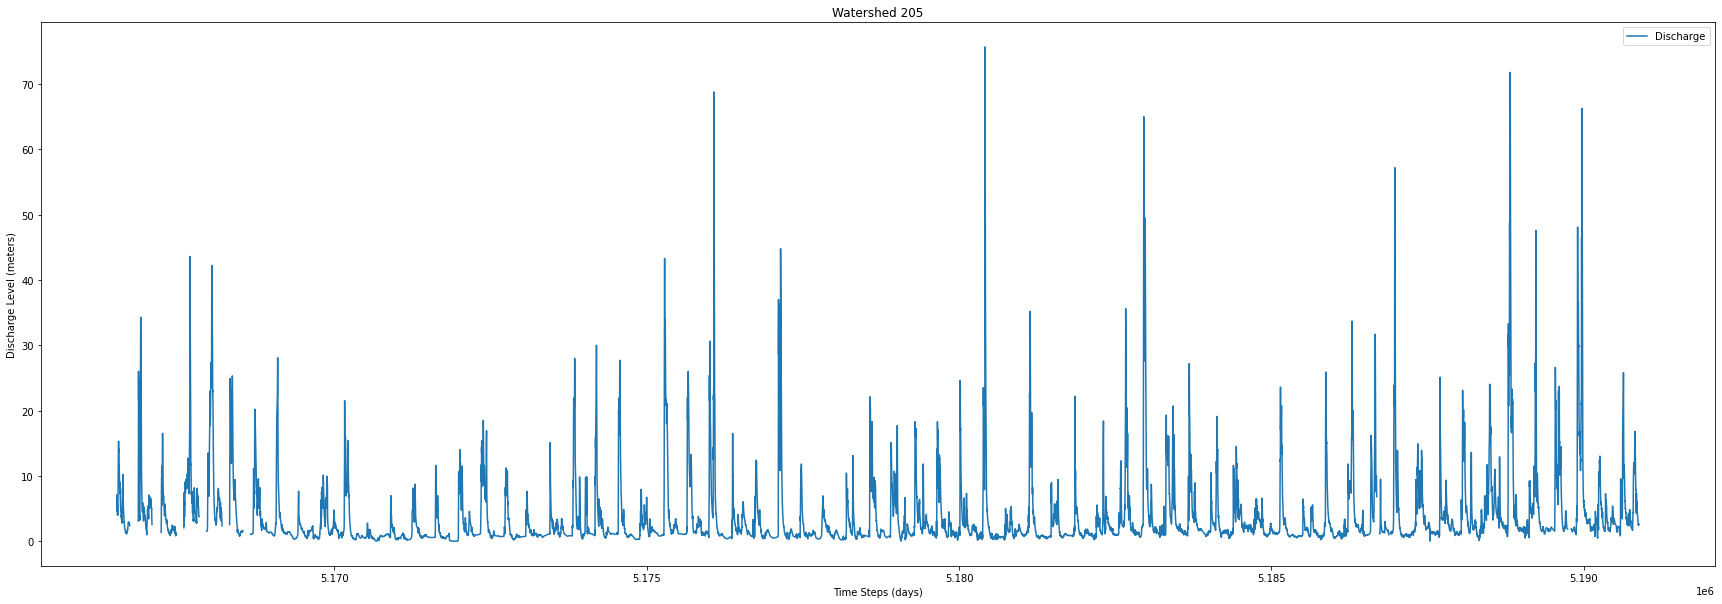

In [ ]:
# For visual representation, plotting discharge of watershed 8

x = range(len(shed205))
y1 = shed205.discharge

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
plt.title("Watershed 205")
plt.xlabel("Time Steps (days)") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Discharge Level (meters)")
plt.plot(y1, label = 'Discharge')




plt.legend()
plt.show()

In [ ]:
# There appears to be a gulf of discharge values right at the end. (Perhaps this watershed's sensor turned off earlier.)
test = shed205.copy()
test.dropna()

,time,watershed,pr,tasmax,tasmin,discharge
5166522,1950-04-23,205,0.074635,5.912317,-2.073695,6.85
5166523,1950-04-24,205,0.000000,3.652505,-3.025574,6.12
5166524,1950-04-25,205,0.000000,2.082985,-4.673486,6.29
5166525,1950-04-26,205,0.000000,1.490501,-5.531106,6.40
5166526,1950-04-27,205,0.000000,5.080793,-6.700000,4.76
...,...,...,...,...,...,...
5190877,2016-12-27,205,1.170564,-10.097390,-22.942066,2.64
5190878,2016-12-28,205,0.929019,-3.541023,-14.312735,2.65
5190879,2016-12-29,205,0.000000,-6.199687,-16.686535,2.61
5190880,2016-12-30,205,0.926618,-10.480793,-16.324427,2.52


In [ ]:
# It appears watershed 8's discharge measurements ended 2016, instead of 2018 like watershed 175. 
shed205 = shed205[(shed205.time < '2017-01-01')]

In [ ]:
# Using Pandas built in function 'interpolate', nan values will be filled in. 
shed205.set_index('time', inplace = True)
for watershedID in set(shed205["watershed"]):
  shed205[shed205["watershed"] == watershedID] = shed205[shed205["watershed"] == watershedID].interpolate(method='time', axis=0, limit_direction="both")

#shed175.dropna(inplace = True)

In [ ]:
# Observe how many nan's remain after interpolation. 
shed205.isnull().sum()

watershed    0
pr           0
tasmax       0
tasmin       0
discharge    0
dtype: int64

In [ ]:
# For experimentation, using a copy saves reloading time. 
model1 = shed205.copy()

In [ ]:
model1.reset_index(inplace=True) 
model1.head()

,time,watershed,pr,tasmax,tasmin,discharge
0,1950-01-01,205,0.819415,-19.975365,-29.133820,6.85
1,1950-01-02,205,0.000000,-24.203758,-27.345928,6.85
2,1950-01-03,205,0.000000,-29.017746,-36.503757,6.85
3,1950-01-04,205,0.000000,-26.956785,-40.761795,6.85
4,1950-01-05,205,0.000000,-30.449478,-39.001670,6.85


In [ ]:
# Herein we will create a function that creates represenations of the past days. 
# A fortnight is the target variable. 

def advance(x):
  num_list = []
  length = len(model1.discharge)
  for i in range(length):
    if x + i >= length: # For calculating the target variable
      num = i
    elif i + x < 0: # For calculating the past. 
      num = i
    else:
      num = i + x # Other than the outliers, the value will be discharge[i + 'x']
    forecast = model1['discharge'][num]
    num_list.append(forecast)
  name = f"discharge_{x}"    
  model1[name] = num_list #model1['discharge'][num]

# tomorrow
# three days (weekend; many prepare for the weekend on Thursday)
# five days (work week)
# Seven days (week)
# Two weeks (two week forecast)
#target_var = 'discharge'
#features = list(shed175.columns.difference([target_var]))

In [ ]:
# One Yesterday's forecast. 
advance(-1)

In [ ]:
# Three days ago.
advance(-3)

In [ ]:
# Five days ago.
advance(-5)

In [ ]:
# One week ago.
advance(-7)

In [ ]:
# The target variable, two weeks out.
advance(14)

In [ ]:
model1.tail(20)

,time,watershed,pr,tasmax,tasmin,discharge,discharge_-1,discharge_-3,discharge_-5,discharge_-7,discharge_14
24452,2016-12-12,205,0.000000,-18.164406,-27.025156,3.82,3.94,4.18,4.40,4.76,2.48
24453,2016-12-13,205,0.000000,-16.172234,-24.161900,3.71,3.82,4.06,4.31,4.31,2.64
24454,2016-12-14,205,0.000000,-20.890396,-26.313570,3.60,3.71,3.94,4.18,4.40,2.65
24455,2016-12-15,205,0.000000,-15.734134,-26.880585,3.50,3.60,3.82,4.06,4.31,2.61
24456,2016-12-16,205,0.000000,-22.829750,-28.378078,3.39,3.50,3.71,3.94,4.18,2.52
24457,2016-12-17,205,0.000000,-24.311274,-32.428288,3.29,3.39,3.60,3.82,4.06,2.57
24458,2016-12-18,205,1.188727,-11.516911,-32.155636,3.20,3.29,3.50,3.71,3.94,3.20
24459,2016-12-19,205,1.088935,-1.979227,-13.009812,3.10,3.20,3.39,3.60,3.82,3.10
24460,2016-12-20,205,0.073486,-0.972338,-14.880480,3.01,3.10,3.29,3.50,3.71,3.01
24461,2016-12-21,205,0.000000,-0.989353,-17.502089,2.92,3.01,3.20,3.39,3.60,2.92


### The initial model.
##### For this initial model, we will only be using the discharge related columns, and precipitation, as the value we will be focusing on. 

In [ ]:
model1.drop(['watershed', 'tasmax', 'tasmin'], axis=1, inplace=True)

model1.head(3)

,time,pr,discharge,discharge_-1,discharge_-3,discharge_-5,discharge_-7,discharge_14
0,1950-01-01,0.819415,6.85,6.85,6.85,6.85,6.85,6.85
1,1950-01-02,0.000000,6.85,6.85,6.85,6.85,6.85,6.85
2,1950-01-03,0.000000,6.85,6.85,6.85,6.85,6.85,6.85


In [ ]:
# We will be focusing on the last twenty years of data.
df = model1[(model1.time >= '1997-01-01')] 

df.head(3)

,time,pr,discharge,discharge_-1,discharge_-3,discharge_-5,discharge_-7,discharge_14
17167,1997-01-01,0.000000,1.32,1.48,1.66,1.28,1.44,1.32
17168,1997-01-02,0.012317,1.39,1.32,1.29,1.52,1.38,1.16
17169,1997-01-03,2.051983,1.46,1.39,1.48,1.66,1.28,1.12


In [ ]:
# The test data will be five years of data (2012 - 2017). 

df_train = df[(df.time < '2012-01-01')]
df_test = df[(df.time >= '2012-01-01')]
print("Test set fraction:", len(df_test) / len(df))

Test set fraction: 0.2501026694045175


In [ ]:
# The 'time' column won't be needed for the RNN model. 
df_train.drop(['time'], axis=1, inplace=True)
df_test.drop(['time'], axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df.drop(['time'], axis=1, inplace=True)

In [ ]:
# Create the target column.
target_sensor = "discharge_14"
# Create the predictor columns.
features = list(df.columns.difference([target_sensor]))
# How far out we are forecasting.
forecast_lead = 14
# Cut off the final 14 days of the dataframe. 
df = df.iloc[:-forecast_lead]

In [ ]:
# For use in the Neural Network. 
target = "discharge_14"

In [ ]:
#test_start = round(0.3*(len(df)))

#df_train = df[:test_start]
#df_test = df[test_start:]

#print("Test set fraction:", len(df_test) / len(df))

In [ ]:
# Standardize the variables. This can also be done through Scikit Learn. 
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

In [ ]:
import torch
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [ ]:
# As example...
i = 27
sequence_length = 4

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)

X, y = train_dataset[i]
print(X)

tensor([[-0.5047, -0.4979, -0.5081, -0.4843, -0.4928, -0.3915],
        [-0.4741, -0.5047, -0.5098, -0.4759, -0.4945, -0.3863],
        [-0.4690, -0.4741, -0.4979, -0.5081, -0.4843, -0.3541],
        [-0.4503, -0.4690, -0.5047, -0.5098, -0.4759, -0.2928]])


In [ ]:
# As example...
X, y = train_dataset[i + 1]
print(X)

tensor([[-0.4741, -0.5047, -0.5098, -0.4759, -0.4945, -0.3863],
        [-0.4690, -0.4741, -0.4979, -0.5081, -0.4843, -0.3541],
        [-0.4503, -0.4690, -0.5047, -0.5098, -0.4759, -0.2928],
        [-0.4385, -0.4504, -0.4742, -0.4979, -0.5081, -0.3915]])


In [ ]:
# As example...
print(df_train[features].iloc[(i - sequence_length + 1): (i + 1)])

       discharge  discharge_-1  discharge_-3  discharge_-5  discharge_-7  \
17191  -0.504673     -0.497899     -0.508111     -0.484345     -0.492838   
17192  -0.474113     -0.504690     -0.509809     -0.475856     -0.494536   
17193  -0.469020     -0.474130     -0.497924     -0.508114     -0.484349   
17194  -0.450345     -0.469037     -0.504715     -0.509811     -0.475860   

             pr  
17191 -0.391488  
17192 -0.386303  
17193 -0.354083  
17194 -0.292847  


In [ ]:
from torch.utils.data import DataLoader
torch.manual_seed(99)

train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True)

X, y = next(iter(train_loader))
print(X.shape)
print(X)

torch.Size([3, 4, 6])
tensor([[[-0.4724, -0.4656, -0.4113, -0.4809, -0.4911, -0.3915],
         [-0.4639, -0.4724, -0.4470, -0.4113, -0.4945, -0.3915],
         [-0.4520, -0.4639, -0.4657, -0.4113, -0.4810, -0.3915],
         [-0.4385, -0.4521, -0.4725, -0.4470, -0.4113, -0.3915]],

        [[-0.4317, -0.4809, -0.4826, -0.4533, -0.4115, -0.3781],
         [-0.3892, -0.4317, -0.4826, -0.4742, -0.4324, -0.3915],
         [-0.3909, -0.3892, -0.4809, -0.4826, -0.4533,  2.2906],
         [-0.3519, -0.3909, -0.4317, -0.4826, -0.4742,  8.2962]],

        [[ 5.8839,  4.6276,  3.9485,  3.6769,  3.8297, -0.3915],
         [ 7.4628,  5.8839,  3.6429,  3.6769,  3.8636, -0.2458],
         [ 7.6156,  7.4629,  4.6276,  3.9485,  3.6769, -0.3915],
         [ 7.1742,  7.6156,  5.8840,  3.6429,  3.6769, -0.2870]]])


In [ ]:
torch.manual_seed(101)

batch_size = 4
sequence_length = 30

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([4, 30, 6])
Target shape: torch.Size([4])


In [ ]:
from torch import nn

class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [ ]:
learning_rate = 5e-5
num_hidden_units = 32 # --> This was 16 in the first version of this model. 

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")

def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")


print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()

for ix_epoch in range(10):
  
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_model(test_loader, model, loss_function)
    print()

Untrained test
--------
Test loss: 1.7569125447836471

Epoch 0
---------
Train loss: 0.8634320923650678
Test loss: 1.3680461917003246

Epoch 1
---------
Train loss: 0.7235438915975664
Test loss: 1.2606448500562502

Epoch 2
---------
Train loss: 0.6852116860112815
Test loss: 1.2203863342561356

Epoch 3
---------
Train loss: 0.6582525055274285
Test loss: 1.2021128003909896

Epoch 4
---------
Train loss: 0.6330633999168003
Test loss: 1.181609229600754

Epoch 5
---------
Train loss: 0.6103589012185587
Test loss: 1.1771955829880578

Epoch 6
---------
Train loss: 0.5893181999519902
Test loss: 1.1841627316063443

Epoch 7
---------
Train loss: 0.57440928935454
Test loss: 1.195759901111128

Epoch 8
---------
Train loss: 0.5573091396936182
Test loss: 1.2103267889116254

Epoch 9
---------
Train loss: 0.5448944400628879
Test loss: 1.2250401574809082



In [ ]:
def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output


train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

       discharge_14  Model forecast
17167          1.32        1.946486
17168          1.16        1.916258
17169          1.12        2.001041
17170          1.04        2.051354
17171          1.03        2.040669
...             ...             ...
24467          2.64        3.194527
24468          2.65        3.190958
24469          2.61        3.153816
24470          2.52        3.130745
24471          2.57        3.084431

[7305 rows x 2 columns]


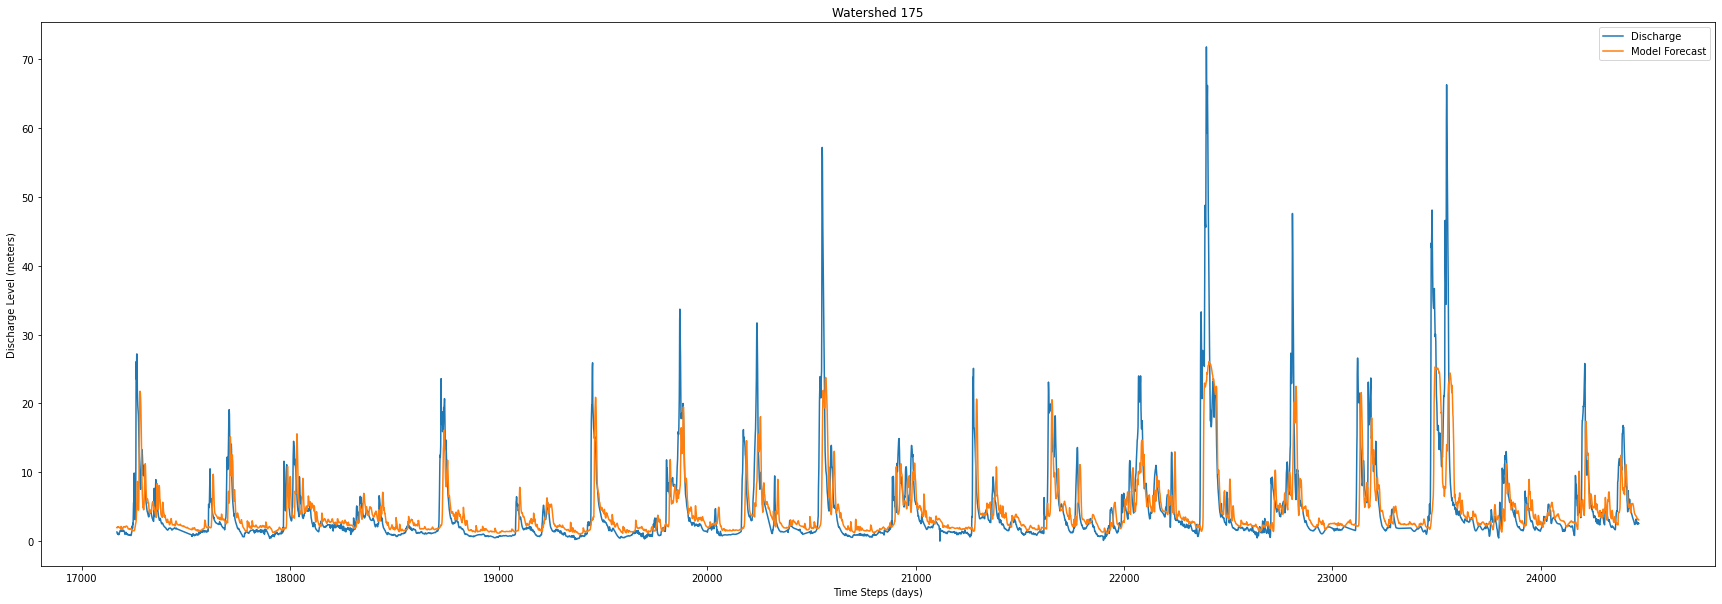

In [ ]:

# Let us observe the predictions and the recorded numbers. 

x = range(len(df_out))
y1 = df_out['discharge_14']
y2 = df_out['Model forecast']

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(10)
plt.title("Watershed 175")
plt.xlabel("Time Steps (days)") # A track varies in timing, but averages to every 3 days.
plt.ylabel("Discharge Level (meters)")
plt.plot(y1, label = 'Discharge')
plt.plot(y2, label = 'Model Forecast')



plt.legend()
plt.show()

In [ ]:
df_out.reset_index(drop=True, inplace=True)
df_out.head()

,discharge_14,Model forecast
0,1.32,1.946486
1,1.16,1.916258
2,1.12,2.001041
3,1.04,2.051354
4,1.03,2.040669


In [ ]:
#SMAPE scoring for twenty years. 

n = len(df) # (7291)
total = 0
for i in range(len(df_out)):
  top = (df_out['Model forecast'][i] - df_out['discharge_14'][i])
  bottom = ((df_out['Model forecast'][i] + df_out['discharge_14'][i]) /2)
  answer = top/bottom
  if answer < 0:
    answer = answer * -1
  total += answer
SMAPE = total/n
SMAPE = SMAPE * 100
SMAPE

49.17970280066096

### There is a pattern to where the model is innacurate...
##### This neural network is one layer with few neurons, and varying timesteps of past discharge levels as input. It will have difficulties predicting a change in amplitude that doesn't roughly follow a pattern. 

### Looking into the future...
##### Obviously the model can be vastly improved with more layers, neurons and epochs without increasing the training time beyond casual acceptance. 
##### Precipitation (and past precipitation) and snow pack levels could be feature engineered and used in the model. 
##### Manually looking up what watershed feeds directly into another would help with the highest discharge predictions. 